#### CMSE 801 Final Project
### &#9989; Julia Hinds
#### &#9989; 12/8/21

# ___Modeling Marathon Paces___

## Background and Motivation

 - Marathon length: 26.2 miles (or 42.2 km)
 - About 1.1 million runners complete a marathon per year$^{1}$
 - Personal connection to project:
     - have completed 12 marathons
     - upcoming marathon (potential application of project)  
 
 
 - Research question:
     - Is it possible to accurately predict finish paces during a marathon?
         

## Methodology

- Data: 2015 San Francisco Marathon$^{2}$ (F-19) , personal marathon splits


First, import all relevent libraries for entire project.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from PIL import Image
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from IPython.display import display, clear_output
import time

Next, use pandas library to read in the data. For this project, there is also a header in the data file so you will want to use the "skip header" flag.

In [2]:
# Read in the data into a pandas dataframe and print the first few lines
df1 = pd.read_csv("racesplits_SFmarathon.csv") # This is the San Franscisco Marathon data
df1.head()

,Mile,Race 1,Race 2,Race 3,Race 4,Race 5,Race 6,Race 7,Race 8,Race 9,...,Race 25,Race 26,Race 27,Race 28,Race 29,Race 30,Race 31,Race 32,Race 33,Race 34
0,2.3,907,947,933,928,1021,956,1036,951,1112,...,1017,825,928,850,1010,817,904,855,851,851
1,5.5,942,1000,1103,933,1027,1001,1059,1030,1145,...,1014,824,933,845,1015,822,903,922,917,917
2,7.5,957,1006,1056,1000,1020,1019,1100,1034,1154,...,1013,832,1007,849,1022,831,909,936,935,935
3,13.3,1009,1021,1040,1032,1024,1031,1110,1043,1151,...,1055,841,946,854,1013,851,930,943,958,958
4,17.1,1039,1039,1045,1012,1035,1042,1121,1102,1143,...,1000,901,943,921,1014,926,930,957,1000,1015


In [3]:
# Read in the data into a pandas dataframe and print the first few lines
df2 = pd.read_csv("racesplits2.csv") # My personal data 
df2 = df2.drop(['Unnamed: 5','Unnamed: 6'],axis=1) # This feature drops columns from the dataframe - which we want because there's no data in these columns
df2.head()

,Mile,Race 1,Race 2,Race 3,Race 4
0,1,1001,1100,1021,1012
1,2,947,1034,954,937
2,3,956,1028,1008,943
3,4,922,1051,1010,934
4,5,948,1209,1011,927


The function below will convert the paces in the data to seconds.

In [4]:
def to_seconds(num): # num is in the format of mmss, i.e. a 9:05 minute mile would read as 905
    '''
    Converts pace input to seconds.

    Inputs:
        Pace in the format mmss (Example: a 9:05 minute mile would read as 905)

    Outputs: 
        Integer in seconds
    '''
    x = [int(a) for a in str(num)] # Takes the integer input and converts to string which can then be stored as a string
    # Selecting the last two characters in the string which corresponds to the seconds component of the pace
    s_1 = x[-1] 
    s_2 = x[-2]
    ss = s_2*10 + s_1 # Adding them together to create total seconds from input pace
    
    # Selecting the first 1 (or 2) characters in the string to convert to the minute component of the pace
    if len(x) == 3:
        mm = x[0]
    if len(x) == 4:
        m_1 = x[0]
        m_2 = x[1]
        mm = m_1*10 + m_2 # Adding them together to create total minutes from input pace
        
    # Checking to make sure no accidental errors when entering the pace information
    if len(x) > 4:
        print("ERROR! Maybe you mistyped the pace?")
        mm = 0
    if len(x) < 3:
        print("ERROR! Maybe you mistyped the pace?")
        mm = 0
    
    # Combining the two above components to determine total pace in seconds
    temp = mm*60 
    tot_time = temp + ss
    
    return(tot_time) # returns (outputs) the pace in seconds


Now apply the function to the data so that the paces are all in seconds/mile.

In [5]:
data1 = df1.copy() # Create a copy of the dataframe in case you want to access it later
# Loop through the dataframe
for i in data1.index: 
    for j in data1.columns:
        if j == "Mile":
            pass # ignore the first column
        else:
            temp = data1.at[i,j] # access the pace at a specific point and store it as a temp variable
            data1.at[i,j] = to_seconds(temp) # convert the pace to seconds and store it 
data1.head() # check to make sure it worked

,Mile,Race 1,Race 2,Race 3,Race 4,Race 5,Race 6,Race 7,Race 8,Race 9,...,Race 25,Race 26,Race 27,Race 28,Race 29,Race 30,Race 31,Race 32,Race 33,Race 34
0,2.3,547,587,573,568,621,596,636,591,672,...,617,505,568,530,610,497,544,535,531,531
1,5.5,582,600,663,573,627,601,659,630,705,...,614,504,573,525,615,502,543,562,557,557
2,7.5,597,606,656,600,620,619,660,634,714,...,613,512,607,529,622,511,549,576,575,575
3,13.3,609,621,640,632,624,631,670,643,711,...,655,521,586,534,613,531,570,583,598,598
4,17.1,639,639,645,612,635,642,681,662,703,...,600,541,583,561,614,566,570,597,600,615


In [6]:
data2 = df2.copy() # Create a copy of the dataframe in case you want to access it later
# Loop through the dataframe
for i in data2.index:
    for j in data2.columns:
        if j == "Mile":
            pass # ignore the first column
        else:
            temp = data2.at[i,j] # access the pace at a specific point and store it as a temp variable
            data2.at[i,j] = to_seconds(temp) # convert the pace to seconds and store it
data2.head() # check to make sure it worked

,Mile,Race 1,Race 2,Race 3,Race 4
0,1,601,660,621,612
1,2,587,634,594,577
2,3,596,628,608,583
3,4,562,651,610,574
4,5,588,729,611,567


Next we'll want to convert the pandas dataframe to a numpy array in order to use sklearn packages. For now, just worry about the first set of data - then apply the same steps to the second set.

In [7]:
# Convert pandas dataframe to numpy array to use sklearn packages
full_data = data1.to_numpy() # turns pd df to np array
y1 = np.delete(full_data, 0, axis=1) # removing the "miles" so we just have the paces
X = full_data[:,0] # storing the first column (miles) and calling it X
X = np.atleast_2d(X).T # converts the 1-D array to a higher order array

In [8]:
# Normalize the data
y = np.mean(y1, axis=1)
dy = np.std(y1, axis=1)
print(y)
y_mean = np.mean(y1)
print(y, dy)

[591.29411765 614.44117647 626.88235294 640.64705882 657.17647059
 664.47058824]
[591.29411765 614.44117647 626.88235294 640.64705882 657.17647059
 664.47058824] [53.40441126 57.92956736 58.71354424 61.75229567 67.13001897 69.57739461]


To first visualize the data, we are using Sklearn's Guassian Process Regressor (documentation can be found here: https://scikit-learn.org/stable/ ). Below code was based on an introductory example.$^{3}$

A gaussian process regression (GPR) is a probabilistic supervised machine learning framework. It makes predictions by incorporating prior knowledge (known as “kernels”) and provide an uncertainty over the predictions. 

These kernels (or, covarience functions) pecify the statistical relationship between two points ($x_{1}$,$x_{2}$) in the input space. Here we are going to use a combination of kernals: ConstantKernal and Radial-basis function (RBF or Squared Exponential Kernel).
- ConstantKernal
    - $k(x_{1}+x_{2}) = constant value \forall x_{1},x_{2}$
- RBF
    - $k(x_{1}+x_{2}) = \sigma^{2}exp(\frac{-d(x_{1},x_{2})^{2}}{2l^{2}})$
    - where $l$ is length scale of kernel, $\sigma^{2}$ is the output variance (essentially a scale factor) and d(.,.) is the Euclidean distance 


In [9]:
# Create a function: sklearn Gaussian Process Regressor
# Alpha is the varience of the noise
kernel = C(1.0, (1e-3, 1e8)) * RBF(1, (1e-2, 1e2)) # create the kernal
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2, n_restarts_optimizer=10) # create the gaussian process regressor


In [10]:
# Use funtion above to fit the data
# It doesn't converge really well becuase there's not a lot of data
gp.fit(X, y)

/Users/julia/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


GaussianProcessRegressor(alpha=array([2852.03114187, 3355.83477509, 3447.28027682, 3813.34602076,
       4506.43944637, 4841.01384083]),
                         kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

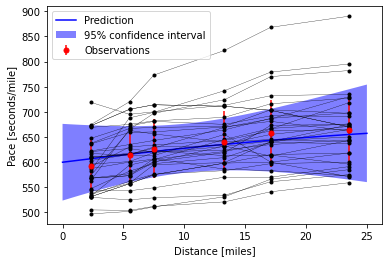

In [11]:
# From the fit, interpolate between the data points so it can be a continuous distribution and plot
x = np.atleast_2d(np.linspace(0, 25, 1000)).T
y_pred, sigma = gp.predict(x, return_std=True)

# Plotting ----------------------
# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.errorbar(X.ravel(), y, dy, fmt="r.", markersize=10, label="Observations") # plots the error bar
plt.plot(x, y_pred, "b-", label="Prediction") # plotting the predicted values (can think of like the fit)
plt.plot(X,y1,"k.") # plotting the actual data
plt.plot(X,y1,"k-", linewidth=0.3) # connecting the data to help visualize

plt.fill( # fills the confidence interval 
    np.concatenate([x, x[::-1]]),
    np.concatenate([y_pred - 1.9600 * sigma, (y_pred + 1.9600 * sigma)[::-1]]),
    alpha=0.5,
    fc="b",
    ec="None",
    label="95% confidence interval",
)
# plotting labels and legend
plt.xlabel("Distance [miles]")
plt.ylabel("Pace [seconds/mile]")
plt.legend(loc="upper left")
# plt.savefig("total_SF_prediction_GPR.png") # uncomment to save figure

The next step in the analysis is to create a "black box" funtion. The inputs into this function will be all of the avaliable data from the 2015 San Francisco Marathon, and the psudo-"live-stream" race paces. The purpose of the funtion is to predict the pace at the end of the race. This is done by having a single function, $f()$, which is to be a linear combination of two additional functions, $f_{1}()$ and $f_{2}()$. These two functions are weighted by two variables, $\alpha$ and $\beta$, which are determined by how much of the race has been completed (example: if you're halfway through the race, $\alpha$ = 0.5 and $\beta$ = 0.5 - so the psudo-"live-stream" paces hold the same weight of the current data). Then, as the race continues, the end pace prediction is updated. 

The figure below shows a schematic of the "black box" methodology:


(-0.5, 1365.5, 276.5, -0.5)

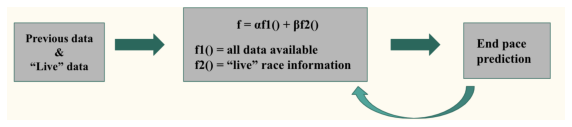

In [12]:
zebra = Image.open("black_box_function.png")
plt.figure(figsize = (10,10))
plt.imshow(zebra)
plt.axis('off')

($f_{1}(), f_{2}(), f_{3}()$) that feed into the main functions ($f()$, and $f_{predict}()$). Additionally, two versions of this function was created: one including a desired end race pace and one without inclusion of desired end pace.

One of the fit options we'll want to include is the logistic fit.$^4$ A logistic regression is desired, but there are limitations with the regression model becuase the regression requires the output (y-values) to be boolean whereas in this project we have race paces. 

In [13]:
# Creating a logistic function (don't think this is the best way to go about this, but the logistic regression doesn't work because the dependent variable is not boolean)
def logistic_func(avgvals,L,k,x0,x):
    '''
    Logistic funtion: f(x) = L/(1+exp(-k(x-x0)))

    Inputs:
        avgvals : Total list of race paces
        L : Curve's maximum values
        k : Logistic growth rate (or steepness of curve)
        x0 : Sigmoid's midpoint
        x : Mile number

    Outputs: 
        Logistic funtion output
    '''
    return np.min(avgvals)+ L/(1+np.exp(-k*(x-x0)))


Next, create a series of funtions ($f_{1}(), f_{2}(), f_{3}()$) that feed into the main functions ($f()$, and $f_{predict}()$). For polynomial fits, numpy polyfit and numpy poly1d are used (documentation: https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html and https://numpy.org/doc/stable/reference/generated/numpy.poly1d.html). 

In [14]:
# Define a first function to fit data provided by previous races (SF Marathon or personal data)

def f1(df,fit="D1"):
    '''
    f1()
    Fits the data in the pandas dataframe using the fit specified
        D1, D2, D3, D4 : uses numpy polyfit and numpy poly1d
        logistic : uses logistic function defined above

    Inputs:
        df : pandas dataframe of total data
        fit : which fit option you would like as a string (Default is degree 1 polynomial)
            options: D1, D2, D3, D4, or logistic

    Outputs: 
        If fit == D1, D2, D3, or D4 -> output parameters
        If fit == logistic -> array of y-values
    '''
    # Define some variables that will be useful later
    miles = df["Mile"]
    avgvals = []
    parameters_a = []

    # We want to loop through all of the miles and determine the average pace at the mile
    for j in range(len(miles)): # loops through all miles
        # define to be zero at the start of each loop
        tempavg = 0 
        count = 0
        for i in range(1,len(df.columns)): # loops through each race at a specific mile and add together
            count += 1 
            mystr = "Race "+str(i)
            x = df[mystr][j]
            tempavg += x
        avg = tempavg/count # divide by the number of races to get average pace
        avgvals.append(avg) # add to a list of all average paces
    
    # Fits --------------------------------------------------------------
    if fit == "D1": # degree 1 polynomial
        # only including comments for polyfit, poly1d, and applying the output function once - come back here to reference if you need help later on
        parameters_a = np.polyfit(miles, avgvals, 1) # polyfit's inputs are x- and y- values, and degree of fitting polynomial
        my_function_a = np.poly1d(parameters_a) # poly1d's inputs are polynomial's coefficients (output from polyfit), generates a funtion
        expected_y_a = my_function_a(miles) # apply the function generated to the x-values to produce predicted (expected) y-values
    if fit == "D2": # degree 2 polynomial
        parameters_a = np.polyfit(miles, avgvals, 2)
        my_function_a = np.poly1d(parameters_a)
        expected_y_a = my_function_a(miles)
    if fit == "D3": # degree 3 polynomial
        parameters_a = np.polyfit(miles, avgvals, 3)
        my_function_a = np.poly1d(parameters_a)
        expected_y_a = my_function_a(miles)
    if fit == "D4": # degree 4 polynomial
        parameters_a = np.polyfit(miles, avgvals, 4)
        my_function_a = np.poly1d(parameters_a)
        expected_y_a = my_function_a(miles)
    if fit == "logistic": # logistic function
        # only including comments for logistic function once - come back here to reference if you need help later on
        L = np.max(avgvals)-np.min(avgvals) # determine curve's maximum value based on the spread of data
        k = np.max(avgvals) # determine steepness of curve based on minimum of data
        x0 = 13.1 # setting midpoint to be halfway through race
        expected_y_a = []
        for x in miles: # for each mile, find the expected pace based on the logistic funtion
            expected_y_a.append(logistic_func(avgvals,L,k,x0,x))
        parameters_a = expected_y_a # will return a list of expected values rather than parameters
        
    # Keep plotting commented out unless you want to test the function, otherwise you end up with A LOT of plots at the end (too many to actually keep track of)
    # Plotting -----------------------------------------------------------
#     figure, (ax1) = plt.subplots(1,1, figsize=[16,8])

#     ax1.plot(miles,avgvals,"go",label='data')
#     ax1.plot(miles, expected_y_a, color = "orange", label = "fit")

#     ax1.title.set_text("Linear fit")
#     ax1.set_xlabel('Mile')
#     ax1.set_ylabel('Pace')
#     ax1.grid()
#     ax1.legend()

#     plt.tight_layout()
    # --------------------------------------------------------------------
    
    return parameters_a # return parameters of fit or expected y-values 
    

    
# # Uncomment below to test f1()
# tempx = [900,900,900,900] # test pace list
# for i in range(len(tempx)): # converts pace list to seconds
#     temp = tempx[i]
#     tempx[i] = to_seconds(temp)
# f1(data1,"logistic") # test funtion


In [15]:
# Define a second function to perform a linear regression based on current data and desired final pace

def f2(df,x_list,ftime,fit="D1"):
    '''
    f2()
    Fits the "live" data with the pandas dataframe using the fit specified, including a desired final pace
        D1, D2, D3, D4 : uses numpy polyfit and numpy poly1d
        logistic : uses logistic function defined above

    Inputs:
        df : pandas dataframe of total data
        x_list : current pace information from "live" event
        ftime : desired final pace
        fit : which fit option you would like as a string (Default is degree 1 polynomial)
            options: D1, D2, D3, D4, or logistic

    Outputs: 
        If fit == D1, D2, D3, or D4 -> output parameters
        If fit == logistic -> array of y-values
    '''
    
    ftime = to_seconds(ftime) # convert the final desired pace to seconds
    
    # Define some variables that will be useful later
    tempmiles = df["Mile"]
    miles = []
    parameters_a = []
    
    for i in range(len(x_list)): # loops through the "live" pace list to see how many miles have been ran
        miles.append(tempmiles[i])
    # add the final desired pace at the end with the mile for the desired pace
    x_list.append(ftime)
    miles.append(26.2)
        
    avgvals = x_list # change of variable name to make similar to other functions
    
    # Fits (see f1() for more details about the fits) --------------
    if fit == "D1":
        parameters_a = np.polyfit(miles, avgvals, 1)
        my_function_a = np.poly1d(parameters_a)
        expected_y_a = my_function_a(miles)
    if fit == "D2":
        parameters_a = np.polyfit(miles, avgvals, 2)
        my_function_a = np.poly1d(parameters_a)
        expected_y_a = my_function_a(miles)
    if fit == "D3":
        parameters_a = np.polyfit(miles, avgvals, 3)
        my_function_a = np.poly1d(parameters_a)
        expected_y_a = my_function_a(miles)
    if fit == "D4":
        parameters_a = np.polyfit(miles, avgvals, 4)
        my_function_a = np.poly1d(parameters_a)
        expected_y_a = my_function_a(miles)
    if fit == "logistic":
        L = np.max(avgvals)-np.min(avgvals)
        k = np.max(avgvals)
        x0 = 13.1
        expected_y_a = []
        for x in miles:
            expected_y_a.append(logistic_func(avgvals,L,k,x0,x))
        parameters_a = expected_y_a
    
    # Keep plotting commented out unless you want to test the function, otherwise you end up with A LOT of plots at the end (too many to actually keep track of)
    # Plotting ---------------------------------------------------------
#     figure, (ax1) = plt.subplots(1,1, figsize=[16,8])

#     ax1.plot(miles,avgvals,"go",label='data')
#     ax1.plot(miles, expected_y_a, color = "orange", label = "fit")

#     ax1.title.set_text("Linear fit")
#     ax1.set_xlabel('Mile')
#     ax1.set_ylabel('Pace')
#     ax1.grid()
#     ax1.legend()

#     plt.tight_layout()
    # ------------------------------------------------------------------
    
    return parameters_a # return parameters of fit or expected y-values 
    
    
# # Uncomment below to test f2()
# tempx = [900,950,960,970] # test pace list
# for i in range(len(tempx)): # converts pace list to seconds
#     temp = tempx[i]
#     tempx[i] = to_seconds(temp)
# f2(data1,tempx,1000,fit="logistic") # tests f2()


In [16]:
# Define a third function to perform a linear regression based on current data NOT DEPENDENT OF DESIRED FINAL PACE

def f3(df,x_list,fit="D1"):
    '''
    f3()
    Fits the "live" data with the pandas dataframe using the fit specified, NOT including a desired final pace
        D1, D2, D3, D4 : uses numpy polyfit and numpy poly1d
        logistic : uses logistic function defined above

    Inputs:
        df : pandas dataframe of total data
        x_list : current pace information from "live" event
        fit : which fit option you would like as a string (Default is degree 1 polynomial)
            options: D1, D2, D3, D4, or logistic

    Outputs: 
        If fit == D1, D2, D3, or D4 -> output parameters
        If fit == logistic -> array of y-values
    '''
    
    # Define some variables that will be useful later
    tempmiles = df["Mile"]
    miles = []
    parameters_a = []
    
    for i in range(len(x_list)): # loops through the "live" pace list to see how many miles have been ran
        miles.append(tempmiles[i])
        
    avgvals = x_list # change of variable name to make similar to other functions
    
    # Fits (see f1() for more details about the fits) --------------
    if fit == "D1":
        parameters_a = np.polyfit(miles, avgvals, 1)
        my_function_a = np.poly1d(parameters_a)
        expected_y_a = my_function_a(miles)
    if fit == "D2":
        parameters_a = np.polyfit(miles, avgvals, 2)
        my_function_a = np.poly1d(parameters_a)
        expected_y_a = my_function_a(miles)
    if fit == "D3":
        parameters_a = np.polyfit(miles, avgvals, 3)
        my_function_a = np.poly1d(parameters_a)
        expected_y_a = my_function_a(miles)
    if fit == "D4":
        parameters_a = np.polyfit(miles, avgvals, 4)
        my_function_a = np.poly1d(parameters_a)
        expected_y_a = my_function_a(miles)
    if fit == "logistic":
        L = np.max(avgvals)-np.min(avgvals) 
        k = np.max(avgvals) 
        x0 = 13.1
        expected_y_a = []
        for x in miles:
            expected_y_a.append(logistic_func(avgvals,L,k,x0,x))
        parameters_a = expected_y_a
    
    # Keep plotting commented out unless you want to test the function, otherwise you end up with A LOT of plots at the end (too many to actually keep track of)
    # Plotting ---------------------------------------------------------
#     figure, (ax1) = plt.subplots(1,1, figsize=[16,8])

#     ax1.plot(miles,avgvals,"go",label='data')
#     ax1.plot(miles, expected_y_a, color = "orange", label = "fit")

#     ax1.title.set_text("Linear fit")
#     ax1.set_xlabel('Mile')
#     ax1.set_ylabel('Pace')
#     ax1.grid()
#     ax1.legend()

#     plt.tight_layout()
    # ------------------------------------------------------------------
    
    return parameters_a # return parameters of fit or expected y-values



# # Uncomment below to test f3()
# tempx = [900,950,960,970] # test pace list
# for i in range(len(tempx)): # converts pace list to seconds
#     temp = tempx[i]
#     tempx[i] = to_seconds(temp)
# f3(data1,tempx,fit="D1") # tests f3()


In [17]:
# This function creates a linear combination of the f1() and f2() and weighs them based on how much of
# the race is completed - INCLUDING DESIRED TIME

def f(df,pace_list,ftime,fit="D1"):
    '''
    f()
    Creates a fit that is a linear combination of the f1() and f2() and weighs them based on how much of the race is completed - INCLUDING desired final pace
        D1, D2, D3, D4 : uses numpy polyfit and numpy poly1d
        logistic : uses logistic function defined above

    Inputs:
        df : pandas dataframe of total data
        pace_list : current pace information from "live" event
        ftime : desired final pace
        fit : which fit option you would like as a string (Default is degree 1 polynomial)
            options: D1, D2, D3, D4, or logistic

    Outputs: 
        If fit == D1, D2, D3, or D4 -> output parameters
        If fit == logistic -> array of y-values
    '''
    
    ftime2 = ftime # create a copy of the desired final pace
    ftime = to_seconds(ftime) # convert the final desired pace to seconds
    
    # Define some variables that will be useful later
    tempmiles = df["Mile"]
    miles = []
    expected_y_a = []
    
    for i in range(len(pace_list)): # loops through the "live" pace list to see how many miles have been ran
        miles.append(tempmiles[i])
    # add the final mile for the desired pace
    miles.append(26.2)
    
    # Determine the weights of each funtion: alpha and beta ------------------------
    f_f = 26.2
    temp_f_2 = len(pace_list) 
    
    # Initially setting to zero
    alpha = 0
    beta = 0

    if temp_f_2 < 26: # as long as the race is not over, calculate alpha and beta
        f_2 = df["Mile"][temp_f_2]
        alpha = (f_f - f_2)/f_f 
        beta = (f_2)/f_f
    if temp_f_2 == 26: # when the race is over, it should fully be the "live" data
        alpha = 0
        beta = 1

    if fit=="D1" or fit=="D2" or fit=="D3" or fit=="D4":
        # call above functions and store the results in variables
        dataset_param = f1(df,fit) 
        current_param = f2(df,pace_list,ftime2,fit)
        
        d = 0 # initalize to zero
        # set the degree
        if fit=="D1":
            d = 1
        if fit=="D2":
            d = 2
        if fit=="D3":
            d = 3
        if fit=="D4":
            d =4
        
        temp_pace = []
        for i in range(len(miles)): # loop through the miles
            # depending on the degree, calulate the predicted pace
            if d == 1:
                aa = dataset_param[0]*miles[i]
                bb = current_param[0]*miles[i]
            if d == 2:
                aa = dataset_param[0]*(miles[i]**2) + dataset_param[1]*(miles[i])
                bb = current_param[0]*(miles[i]**2) + current_param[1]*(miles[i])
            if d == 3:
                aa = dataset_param[0]*(miles[i]**3) + dataset_param[1]*(miles[i]**2) + dataset_param[2]*(miles[i])
                bb = current_param[0]*(miles[i]**3) + current_param[1]*(miles[i]**2) + current_param[2]*(miles[i])
            if d == 4:
                aa = dataset_param[0]*(miles[i]**4) + dataset_param[1]*(miles[i]**3) + dataset_param[2]*(miles[i]**2) + dataset_param[3]*(miles[i])
                bb = current_param[0]*(miles[i]**4) + current_param[1]*(miles[i]**3) + current_param[2]*(miles[i]**2) + current_param[3]*(miles[i])
            func = (alpha*(aa + dataset_param[-1]) + beta*(bb + current_param[-1]))
            temp_pace.append(func)
        
        parameters_a = np.polyfit(miles, temp_pace, d) # polyfit's inputs are x- and y- values, and degree of fitting polynomial
        my_function_a = np.poly1d(parameters_a) # poly1d's inputs are polynomial's coefficients (output from polyfit), generates a funtion
        expected_y_a = my_function_a(miles) # apply the function generated to the x-values to produce predicted (expected) y-values
    
    if fit=="logistic": # logistic function
        # call above functions and store the results in variables
        dataset_y = f1(df,fit)
        current_y = f2(df,pace_list,ftime2,fit)
        
        temp_pace = []
        for i in range(len(current_y)): # loop through the miles
            func = alpha*(dataset_y[i]) + beta*(current_y[i]) # using the functions above, calulate the predicted pace
            temp_pace.append(func) 
        
        L = np.max(pace_list)-np.min(pace_list) # determine curve's maximum value based on the spread of data
        k = np.max(pace_list) # determine steepness of curve based on minimum of data
        x0 = 13.1 # setting midpoint to be halfway through race
        for x in miles: # for each mile, find the expected pace based on the logistic funtion
            expected_y_a.append(logistic_func(pace_list,L,k,x0,x))
        parameters_a = expected_y_a # will return a list of expected values rather than parameters
        
    # Keep plotting commented out unless you want to test the function, otherwise you end up with A LOT of plots at the end (too many to actually keep track of)    
    # Plotting -------------------------------------------------------------------
#     figure, (ax1) = plt.subplots(1,1, figsize=[16,8])

#     ax1.plot(miles,pace_list,"go",label='data')
#     ax1.plot(miles, expected_y_a, color = "orange", label = "fit")

#     ax1.title.set_text("Linear fit")
#     ax1.set_xlabel('Mile')
#     ax1.set_ylabel('Pace')
#     ax1.grid()
#     ax1.legend()
    
#     plt.tight_layout()
    # ------------------------------------------------------------------------------
    
    return parameters_a # return parameters of fit or expected y-values
    
    
# # Uncomment below to test f()
# pace_list = [900,950,1100] # test pace list
# for i in range(len(pace_list)): # converts pace list to seconds
#     temp = pace_list[i]
#     pace_list[i] = to_seconds(temp)
# ftime = 1000
# f(data1,pace_list,ftime,fit="D2") # tests f()

In [18]:
# This function creates a linear combination of the f1() and f3() and weighs them based on how much of
# the race is completed - NOT INCLUDING DESIRED TIME

def f_predict(df,pace_list,fit="D1"):
    '''
    f_predict()
    Creates a fit that is a linear combination of the f1() and f2() and weighs them based on how much of the race is completed - NOT INCLUDING desired final pace
        D1, D2, D3, D4 : uses numpy polyfit and numpy poly1d
        logistic : uses logistic function defined above

    Inputs:
        df : pandas dataframe of total data
        pace_list : current pace information from "live" event
        ftime : desired final pace
        fit : which fit option you would like as a string (Default is degree 1 polynomial)
            options: D1, D2, D3, D4, or logistic

    Outputs: 
        If fit == D1, D2, D3, or D4 -> output parameters
        If fit == logistic -> array of y-values
    '''
    
    # Define some variables that will be useful later
    f_f = 26.2
    temp_f_2 = len(pace_list)
    expected_y_a = []
    alpha = 0
    beta = 0
    
    if temp_f_2 < 26: # as long as the race is not over, calculate alpha and beta
        f_2 = df["Mile"][temp_f_2]
        alpha = (f_f - f_2)/f_f
        beta = (f_2)/f_f
    if temp_f_2 == 26: # when the race is over, it should fully be the "live" data
        alpha = 0
        beta = 1
    
    tempmiles = df["Mile"]
    miles = []
    for i in range(len(pace_list)): # loops through the "live" pace list to see how many miles have been ran
        miles.append(tempmiles[i])
        
    if fit=="D1" or fit=="D2" or fit=="D3" or fit=="D4":
        # call above functions and store the results in variables
        dataset_param = f1(df,fit)
        current_param = f3(df,pace_list,fit)
        
        d = 0 # initalize to zero
        # set the degree
        if fit=="D1":
            d = 1
        if fit=="D2":
            d = 2
        if fit=="D3":
            d = 3
        if fit=="D4":
            d =4
        
        temp_pace = []
        for i in range(len(miles)): # loop through the miles
            # depending on the degree, calulate the predicted pace
            if d == 1:
                aa = dataset_param[0]*miles[i]
                bb = current_param[0]*miles[i]
            if d == 2:
                aa = dataset_param[0]*(miles[i]**2) + dataset_param[1]*(miles[i])
                bb = current_param[0]*(miles[i]**2) + current_param[1]*(miles[i])
            if d == 3:
                aa = dataset_param[0]*(miles[i]**3) + dataset_param[1]*(miles[i]**2) + dataset_param[2]*(miles[i])
                bb = current_param[0]*(miles[i]**3) + current_param[1]*(miles[i]**2) + current_param[2]*(miles[i])
            if d == 4:
                aa = dataset_param[0]*(miles[i]**4) + dataset_param[1]*(miles[i]**3) + dataset_param[2]*(miles[i]**2) + dataset_param[3]*(miles[i])
                bb = current_param[0]*(miles[i]**4) + current_param[1]*(miles[i]**3) + current_param[2]*(miles[i]**2) + current_param[3]*(miles[i])
            func = (alpha*(aa + dataset_param[-1]) + beta*(bb + current_param[-1]))
            temp_pace.append(func)
        
        parameters_a = np.polyfit(miles, temp_pace, d) # polyfit's inputs are x- and y- values, and degree of fitting polynomial
        my_function_a = np.poly1d(parameters_a) # poly1d's inputs are polynomial's coefficients (output from polyfit), generates a funtion
        expected_y_a = my_function_a(miles) # apply the function generated to the x-values to produce predicted (expected) y-values
        
    if fit=="logistic": # logistic function
        # call above functions and store the results in variables
        dataset_y = f1(df,fit)
        current_y = f3(df,pace_list,fit)
        
        temp_pace = []
        for i in range(len(current_y)): # loop through the miles
            func = alpha*(dataset_y[i]) + beta*(current_y[i]) # using the functions above, calulate the predicted pace
            temp_pace.append(func)
        
        L = np.max(pace_list)-np.min(pace_list) # determine curve's maximum value based on the spread of data
        k = np.max(pace_list) # determine steepness of curve based on minimum of data
        x0 = 13.1 # setting midpoint to be halfway through race
        for x in miles: # for each mile, find the expected pace based on the logistic funtion
            expected_y_a.append(logistic_func(pace_list,L,k,x0,x))
        parameters_a = expected_y_a # will return a list of expected values rather than parameters
    
    # Keep plotting commented out unless you want to test the function, otherwise you end up with A LOT of plots at the end (too many to actually keep track of)    
    # Plotting -------------------------------------------------------------------
#     figure, (ax1) = plt.subplots(1,1, figsize=[16,8])

#     ax1.plot(miles,pace_list,"go",label='data')
#     ax1.plot(miles, expected_y_a, color = "orange", label = "fit")

#     ax1.title.set_text("Linear fit")
#     ax1.set_xlabel('Mile')
#     ax1.set_ylabel('Pace')
#     ax1.grid()
#     ax1.legend()
    
#     plt.tight_layout()
    # ------------------------------------------------------------------------------
    
    return parameters_a # return parameters of fit or expected y-values
    
    
    
# # Uncomment below to test f_predict()
# pace_list = [900,950,1100] # test pace list
# for i in range(len(pace_list)): # converts pace list to seconds
#     temp = pace_list[i]
#     pace_list[i] = to_seconds(temp)
# # ftime = 1000
# f_predict(data1,pace_list,fit="D1") # tests f_predict()


In [19]:
# This function runs both f() and f_predict() and plots an animation as the race progresses

def Running(df,total_pace_list,ftime,fit="D1"): # Makes an animation
    '''
    Running()
    Takes previous run data and current "live" data and plots with lines of best fit
        Plots both with a desired final time and without a desired final time

    Inputs:
        df : pandas dataframe of total data
        total_pace_list : current pace information from "live" event
        ftime : desired final pace
        fit : which fit option you would like as a string (Default is degree 1 polynomial)
            options: D1, D2, D3, D4, or logistic

    Outputs: 
        Plots animation of running pace with fits
    '''
    
    ftime2 = ftime # create a copy of the desired final pace
    ftime = to_seconds(ftime) # convert the final desired pace to seconds
    
    # Initializing empty lists that will be useful later
    gvariable = []
    endpaceprojectionw = []
    endpaceprojectionwout = []
    mymiles1 = []
    mymiles2 = []

    # defining figure outside of for-loop for animation
    fig = plt.figure(figsize=(5,5))

    pace_list = []
    j = 0 # set counter to zero
    
    for i in range(len(total_pace_list)): # Run animation

        # Go through the race by split -----------------------------

        pace_list.append(total_pace_list[j])
        j += 1

        # Get fits from the functions -------------------------------
        parameters_b = f_predict(df,pace_list,fit)
        parameters_a = f(df,pace_list,ftime2,fit)

        # -----------------------------------------------------------
        marathon = np.arange(0,27,1)
        
        # defining some useful variables
        miles = []
        tempmiles = df["Mile"]
        
        for i in range(len(pace_list)): # goes through the "live" paces to determine how many miles have been run
            if i < 26:
                miles.append(tempmiles[i])
        mymiles = miles

        if fit=="D1" or fit=="D2" or fit=="D3" or fit=="D4":

            d = 0 # initializing to zero
            # defining the polynomial degree
            if fit=="D1":
                d = 1
            if fit=="D2":
                d = 2
            if fit=="D3":
                d = 3
            if fit=="D4":
                d =4

            y_list2 = []
            y_list1 = []
            for mile in marathon: # looping through all of the splits
                # depending on the degree, calulate the predicted pace (one for f() and one for f_predict())
                if d == 1:
                    aa = parameters_a[0]*mile
                    bb = parameters_b[0]*mile
                if d == 2:
                    aa = parameters_a[0]*(mile**2) + parameters_a[1]*(mile)
                    bb = parameters_b[0]*(mile**2) + parameters_b[1]*(mile)
                if d == 3:
                    aa = parameters_a[0]*(mile**3) + parameters_a[1]*(mile**2) + parameters_a[2]*(mile)
                    bb = parameters_b[0]*(mile**3) + parameters_b[1]*(mile**2) + parameters_b[2]*(mile)
                if d == 4:
                    aa = parameters_a[0]*(mile**4) + parameters_a[1]*(mile**3) + parameters_a[2]*(mile**2) + parameters_a[3]*(mile)
                    bb = parameters_b[0]*(mile**4) + parameters_b[1]*(mile**3) + parameters_b[2]*(mile**2) + parameters_b[3]*(mile)
                func1 = ((aa + parameters_a[-1]))
                func2 = (bb + parameters_b[-1])
                # store paces in lists
                y_list1.append(func1)
                y_list2.append(func2)

        if fit=="logistic": # logistic function
            y_list2 = []
            y_list1 = []
        
            # re-label to stop myself from confusing it with above variables
            valsb = parameters_b
            valsa = parameters_a

            # define variables for logistic function (one for f() and one for f_predict())
            L1 = np.max(valsa)-np.min(valsa) # determine curve's maximum value based on the spread of data
            k1 = np.max(valsa) # determine steepness of curve based on minimum of data
            L2 = np.max(valsb)-np.min(valsb) # determine curve's maximum value based on the spread of data
            k2 = np.max(valsb) # determine steepness of curve based on minimum of data
            x0 = 13.1 # setting midpoint to be halfway through race
            for x in marathon: # for each mile, find the expected pace based on the logistic funtion
                y_list1.append(logistic_func(valsa,L1,k1,x0,x)) # will store a list of expected values rather than parameters
                y_list2.append(logistic_func(valsb,L2,k2,x0,x)) # will store a list of expected values rather than parameters

        # Find end race pace -------------------------------------------
        # get the last element in the list of race paces
        PacewDesired = y_list1[-1]
        PacewoutDesired = y_list2[-1]
        # add it to a list to access outside of loops 
        endpaceprojectionw.append(y_list1[-1])
        endpaceprojectionwout.append(y_list2[-1])

        if len(pace_list) > 20: # only applicable for second dataset
            # just looking at integer miles
            miles = miles[0:26] 
            pace_list = pace_list[0:26]
            marathon = marathon[0:26]
            y_list1 = y_list1[0:26]
            y_list2 = y_list2[0:26]

        # Plotting ----------------------------------------------------
        plt.plot(miles,pace_list,"go",label='data') # plotting data as green points
        plt.plot(marathon, y_list1, color = "blue", label = "expected data with desired pace") # plotting f()
        plt.plot(marathon, y_list2, color = "black", label = "expected data without desired pace") # plotting f_predict()
        # making the plot look nice
        plt.legend(loc="upper left")
        plt.xlabel("Distance [miles]")
        plt.ylabel("Pace [seconds/mile]") 
        plt.ylim([500,800]) # keeps axis from changing during animation

        # Animation ---------------------------------------------------
        # taken from pre-class/in-class
        time.sleep(0.5)         # Sleep for half a second to slow down the animation
        clear_output(wait=True) # Clear output for dynamic display
        display(fig)            # Reset display
        
        # uncomment to save each iteration of the animation
#         tempname = "runningAnimation_SFsplits_"+str(i)+".png" 
#         plt.savefig(tempname) 

        fig.clear()             # Prevent overlapping and layered plots
        
        pace_list.pop() # removed the ftime from being counted during each loop

    plt.close()                 # Close dynamic display
    
    print("Projected finish time (with a desired end pace):",endpaceprojectionw)
    print("Projected finish time (withOUT a desired end pace):",endpaceprojectionwout)
    
    return # doesn't return anything

# uncomment to test Running()
# total_pace_list = [900,950,1100,1000,1040]
# for i in range(len(total_pace_list)):
#     temp = total_pace_list[i]
#     total_pace_list[i] = to_seconds(temp)
# ftime = 1030
# Running(data1,total_pace_list,ftime)


Now apply the "black box" function to the data!

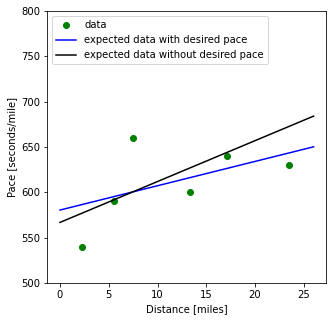

Projected finish time (with a desired end pace): [669.7467236646428, 666.694003967951, 661.2386942793977, 653.3836668646783, 650.1031753116204]
Projected finish time (withOUT a desired end pace): [3622.735177939024, 746.2914143679253, 875.428131771653, 689.292239205973, 684.0008419668034]


In [20]:
# Applying function to data1
total_pace_list = [900,950,1100,1000,1040] # test pace list
for i in range(len(total_pace_list)): # converts pace list to seconds
    temp = total_pace_list[i]
    total_pace_list[i] = to_seconds(temp)
ftime = 1030 # desired final pace
Running(data1,total_pace_list,ftime,fit="D1") # running funtion for D=1 

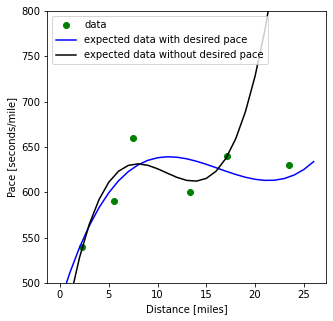

Projected finish time (with a desired end pace): [661.7291718940336, 660.5157108206743, 662.2448915298368, 639.5569057963282, 633.7675835842867]
Projected finish time (withOUT a desired end pace): [230223.10837284144, -11008.19869890634, 3223.601594416698, -3078.9140738959877, 1236.8566597687409]


In [21]:
total_pace_list = [900,950,1100,1000,1040] # test pace list
for i in range(len(total_pace_list)): # converts pace list to seconds
    temp = total_pace_list[i]
    total_pace_list[i] = to_seconds(temp)
ftime = 1030 # desired final pace
Running(data1,total_pace_list,ftime,fit="D3") # running funtion for D=3

Now, apply above steps to second dataset. Start with Gaussian Process Regressor then apply "black box" function.

In [22]:
# Convert pandas dataframe to numpy array to use sklearn packages
full_data2 = data2.to_numpy() # turns pd df to np array
y12 = np.delete(full_data2, 0, axis=1) # removing the "miles" so we just have the paces
X2 = full_data2[:,0] # storing the first column (miles) and calling it X
X2 = np.atleast_2d(X2).T # converts the 1-D array to a higher order array

In [23]:
# Normalize the data
y2 = np.mean(y12, axis=1)
dy2 = np.std(y12, axis=1)
print(y2)
y_mean2 = np.mean(y12)
print(y2, dy2)

[623.5  598.   603.75 599.25 623.75 642.5  641.   636.   675.25 662.25
 722.75 695.75 670.   699.   757.   718.5  721.   701.5  736.5  774.5
 739.5  715.5  763.25 762.   784.   729.  ]
[623.5  598.   603.75 599.25 623.75 642.5  641.   636.   675.25 662.25
 722.75 695.75 670.   699.   757.   718.5  721.   701.5  736.5  774.5
 739.5  715.5  763.25 762.   784.   729.  ] [22.23173408 21.64486082 16.55860803 34.70860844 62.72708745 53.36899849
 48.80061475 34.53983208 40.03982393 44.67871417 60.42091939 55.97934887
 48.34769901 50.01499775 60.78239877 17.16828471 58.82601465 39.55692101
 59.70552738 42.36448985 43.5803855  59.2558014  76.70519865 37.23573552
 68.92387105 89.62700486]


In [24]:
# Create a function: sklearn Gaussian Process Regressor
# Alpha is the varience of the noise
kernel2 = C(1.0, (1e-3, 1e8)) * RBF(1, (1e-2, 1e2)) # create the kernal
gp2 = GaussianProcessRegressor(kernel=kernel2, alpha=dy2 ** 2, n_restarts_optimizer=10) # create the gaussian process regressor


In [25]:
# Use funtion above to fit the data
gp2.fit(X2, y2)

GaussianProcessRegressor(alpha=array([ 494.25  ,  468.5   ,  274.1875, 1204.6875, 3934.6875, 2848.25  ,
       2381.5   , 1193.    , 1603.1875, 1996.1875, 3650.6875, 3133.6875,
       2337.5   , 2501.5   , 3694.5   ,  294.75  , 3460.5   , 1564.75  ,
       3564.75  , 1794.75  , 1899.25  , 3511.25  , 5883.6875, 1386.5   ,
       4750.5   , 8033.    ]),
                         kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

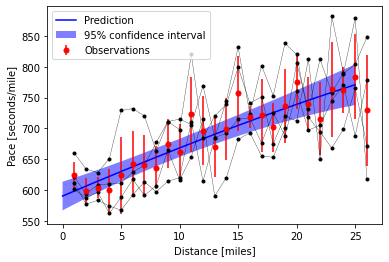

In [26]:
# From the fit, interpolate between the data points so it can be a continuous distribution and plot
x2 = np.atleast_2d(np.linspace(0, 25, 1000)).T
y_pred2, sigma2 = gp2.predict(x2, return_std=True)

# Plotting ----------------------
# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.errorbar(X2.ravel(), y2, dy2, fmt="r.", markersize=10, label="Observations") # plots the error bar
plt.plot(x2, y_pred2, "b-", label="Prediction") # plotting the predicted values (can think of like the fit)
plt.plot(X2,y12,"k.") # plotting the actual data
plt.plot(X2,y12,"k-", linewidth=0.3) # connecting the data to help visualize

plt.fill( # fills the confidence interval 
    np.concatenate([x2, x2[::-1]]),
    np.concatenate([y_pred2 - 1.9600 * sigma2, (y_pred2 + 1.9600 * sigma2)[::-1]]),
    alpha=0.5,
    fc="b",
    ec="None",
    label="95% confidence interval",
)
# plotting labels and legend
plt.xlabel("Distance [miles]")
plt.ylabel("Pace [seconds/mile]")
plt.legend(loc="upper left")
# plt.savefig("my_marathon_prediction_GPR.png") # uncomment to save the plot

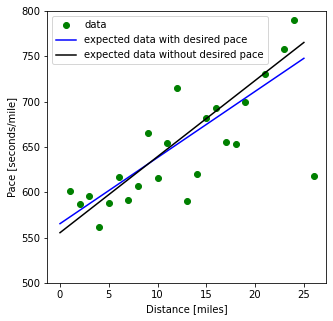

Projected finish time (with a desired end pace): [766.4972247853927, 760.8049591739658, 755.1388065079836, 749.0236006494605, 743.1997943475258, 738.1642460331227, 732.2267996640572, 726.9844446199519, 725.6350927227788, 720.9077774645988, 719.6946585900711, 725.2980453896012, 716.0807166636869, 710.2826909853034, 712.8214646952189, 716.4015134111617, 713.3929752928922, 709.4873329450646, 712.2940043180422, 730.1687307176418, 733.8508698239526, 748.0510785798915, 751.6930231147443, 758.2605404843749, 774.944084161149, 755.0736850587809]
Projected finish time (withOUT a desired end pace): [8181.2560921902505, 717.4767403927725, 740.6778723820698, 692.8548313433821, 707.1946401774628, 736.5280876883922, 726.2559372349444, 727.8081233863683, 758.7544692372935, 748.851699615058, 756.5714529321403, 783.8368921155168, 752.5913257649897, 737.975300356979, 744.5469269915845, 750.4430335355906, 742.5766793701227, 734.0795251747202, 736.6127379272214, 759.9886389000496, 761.7333626932855, 777.00

In [27]:
# apply "black box" function to second dataset
total_pace_list = data2["Race 1"] # use the first race data as the "live" data
ftime = 1030 # desired end pace

Running(data2,total_pace_list,ftime,fit="D1") # running the function for D=1

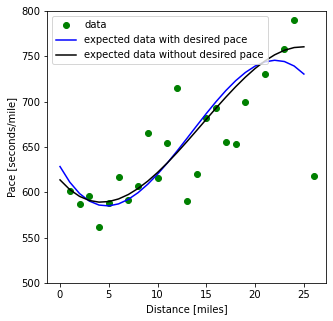

Projected finish time (with a desired end pace): [737.9830825404646, 733.6578086517366, 739.3982666989583, 721.4749206977717, 724.093667644972, 723.3544229462723, 715.5156708059588, 710.6522633845267, 708.7791800084112, 702.1641965180363, 697.8416099023459, 695.1807001250615, 687.0779711458039, 681.1050974196648, 677.5686921710235, 674.0722134618087, 668.4414019337901, 662.5830411385869, 660.3267119410299, 669.4757250862331, 669.716009476348, 686.4445819639088, 693.4497842987483, 712.4522755512601, 761.007828011702, 717.2192461619834]
Projected finish time (withOUT a desired end pace): [2742633.793871796, -328366.98261110805, 30272.92369967011, -26998.23978725162, 9540.383619926984, 7226.041560001711, -1862.4175482687751, -776.836968491863, 2135.1071374956005, -475.20490579584737, 144.94293877715262, 1255.1353952268719, -613.3883939099192, -468.2207756664692, 291.05400199442977, 615.5758928608373, 519.6924447953336, 498.45643093193155, 649.4272525158611, 937.8109908845597, 867.07181853

In [28]:
total_pace_list = data2["Race 1"] # use the first race data as the "live" data
ftime = 1030 # desired end pace
Running(data2,total_pace_list,ftime,fit="D3") # running the function for D=3

To validate the "black box" function, create "perfect" data and see if function is accurate

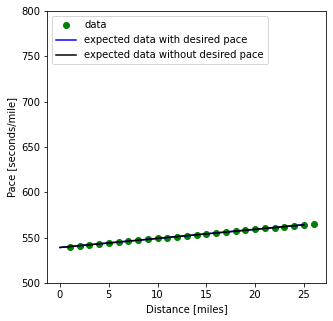

Projected finish time (with a desired end pace): [761.6135461230882, 753.5217261238449, 745.4296330022064, 737.3369458931653, 729.2432008055544, 721.1477927236324, 713.0499990820739, 704.949031028117, 696.8441135615194, 688.7345865825641, 680.6200085454219, 672.5002376691157, 664.375467463494, 656.2462050495046, 648.1131980478556, 639.9773306715298, 631.8395155500903, 623.7006036312827, 615.561324266831, 607.4222569109627, 599.2838285800251, 591.146328303568, 583.0099301959226, 574.8747188358459, 566.7407130266579, 565.1023785147972]
Projected finish time (withOUT a desired end pace): [8118.393496770403, 753.4309388660508, 745.3089156390661, 737.1868924120831, 729.0648691850972, 720.9428459581125, 712.8208227311279, 704.6987995041436, 696.5767762771576, 688.4547530501733, 680.3327298231878, 672.2107065962016, 664.0886833692176, 655.9666601422323, 647.8446369152485, 639.7226136882631, 631.6005904612771, 623.4785672342924, 615.356544007307, 607.2345207803229, 599.1124975533368, 590.99047

In [29]:
# Validation
perfect_pace = np.arange(900,926,1) # creating "perfect" paces
for i in range(len(perfect_pace)): # converting paces to seconds
    temp = perfect_pace[i]
    perfect_pace[i] = to_seconds(temp)
ftime = 926 # desired final pace

Running(data2,perfect_pace,ftime,fit="D1") # running the validation with D=1

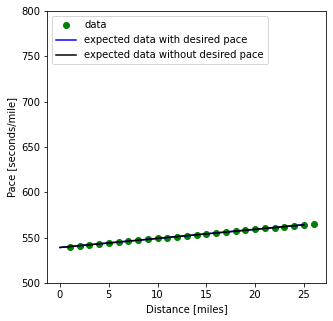

Projected finish time (with a desired end pace): [761.6135461230882, 753.5217261238449, 745.4296330022064, 737.3369458931653, 729.2432008055544, 721.1477927236324, 713.0499990820739, 704.949031028117, 696.8441135615194, 688.7345865825641, 680.6200085454219, 672.5002376691157, 664.375467463494, 656.2462050495046, 648.1131980478556, 639.9773306715298, 631.8395155500903, 623.7006036312827, 615.561324266831, 607.4222569109627, 599.2838285800251, 591.146328303568, 583.0099301959226, 574.8747188358459, 566.7407130266579, 565.1023785147972]
Projected finish time (withOUT a desired end pace): [8118.393496770403, 753.4309388660508, 745.3089156390661, 737.1868924120831, 729.0648691850972, 720.9428459581125, 712.8208227311279, 704.6987995041436, 696.5767762771576, 688.4547530501733, 680.3327298231878, 672.2107065962016, 664.0886833692176, 655.9666601422323, 647.8446369152485, 639.7226136882631, 631.6005904612771, 623.4785672342924, 615.356544007307, 607.2345207803229, 599.1124975533368, 590.99047

In [30]:
perfect_pace = np.arange(900,926,1) # creating "perfect" paces
for i in range(len(perfect_pace)): # converting paces to seconds
    temp = perfect_pace[i]
    perfect_pace[i] = to_seconds(temp)
ftime = 926 # desired final pace
Running(data2,perfect_pace,ftime,fit="D1") # running the validation with D=3

## Results and Discussion

Using Sklearn's Gaussian Process Regressor on both datasets, you can see that there is some trend to the race paces as the marathon progresses, but it is not just a simple linear (or even polynomial) fit. This can be see in the two plots below:

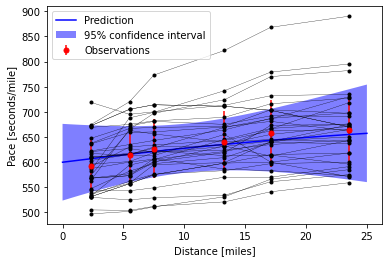

In [31]:
# Plotting ----------------------
# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.errorbar(X.ravel(), y, dy, fmt="r.", markersize=10, label="Observations") # plots the error bar
plt.plot(x, y_pred, "b-", label="Prediction") # plotting the predicted values (can think of like the fit)
plt.plot(X,y1,"k.") # plotting the actual data
plt.plot(X,y1,"k-", linewidth=0.3) # connecting the data to help visualize

plt.fill( # fills the confidence interval 
    np.concatenate([x, x[::-1]]),
    np.concatenate([y_pred - 1.9600 * sigma, (y_pred + 1.9600 * sigma)[::-1]]),
    alpha=0.5,
    fc="b",
    ec="None",
    label="95% confidence interval",
)
# plotting labels and legend
plt.xlabel("Distance [miles]")
plt.ylabel("Pace [seconds/mile]")
plt.legend(loc="upper left")
# plt.savefig("total_SF_prediction_GPR.png") # uncomment to save figure

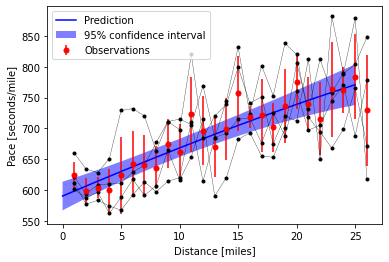

In [32]:
# Plotting ----------------------
# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.errorbar(X2.ravel(), y2, dy2, fmt="r.", markersize=10, label="Observations") # plots the error bar
plt.plot(x2, y_pred2, "b-", label="Prediction") # plotting the predicted values (can think of like the fit)
plt.plot(X2,y12,"k.") # plotting the actual data
plt.plot(X2,y12,"k-", linewidth=0.3) # connecting the data to help visualize

plt.fill( # fills the confidence interval 
    np.concatenate([x2, x2[::-1]]),
    np.concatenate([y_pred2 - 1.9600 * sigma2, (y_pred2 + 1.9600 * sigma2)[::-1]]),
    alpha=0.5,
    fc="b",
    ec="None",
    label="95% confidence interval",
)
# plotting labels and legend
plt.xlabel("Distance [miles]")
plt.ylabel("Pace [seconds/mile]")
plt.legend(loc="upper left")
# plt.savefig("my_marathon_prediction_GPR.png") # uncomment to save the plot

From the second plot, there seems to be more of a positive correlation indicating that having more splits might provide more insight into the actual model for race paces.

Next we can look at the animations from the "black box" function to see if having a linear combination of functions weighted by how far into the race the "live-streaming" is can actually be a good model.

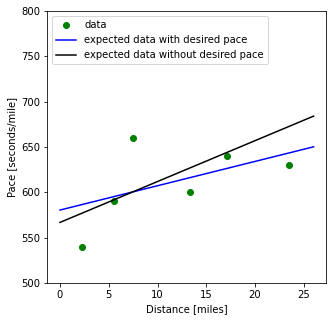

Projected finish time (with a desired end pace): [669.7467236646428, 666.694003967951, 661.2386942793977, 653.3836668646783, 650.1031753116204]
Projected finish time (withOUT a desired end pace): [3622.735177939024, 746.2914143679253, 875.428131771653, 689.292239205973, 684.0008419668034]


In [33]:
total_pace_list = [900,950,1100,1000,1040] # test pace list
for i in range(len(total_pace_list)): # converts pace list to seconds
    temp = total_pace_list[i]
    total_pace_list[i] = to_seconds(temp)
ftime = 1030 # desired final pace
Running(data1,total_pace_list,ftime,fit="D1") # running funtion for D=1

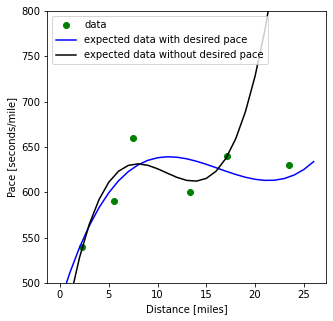

Projected finish time (with a desired end pace): [661.7291718940336, 660.5157108206743, 662.2448915298368, 639.5569057963282, 633.7675835842867]
Projected finish time (withOUT a desired end pace): [230223.10837284144, -11008.19869890634, 3223.601594416698, -3078.9140738959877, 1236.8566597687409]


In [34]:
total_pace_list = [900,950,1100,1000,1040] # test pace list
for i in range(len(total_pace_list)): # converts pace list to seconds
    temp = total_pace_list[i]
    total_pace_list[i] = to_seconds(temp)
ftime = 1030 # desired final pace
Running(data1,total_pace_list,ftime,fit="D3") # running funtion for D=3

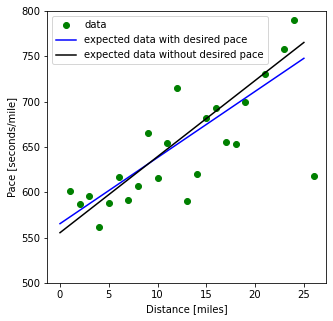

Projected finish time (with a desired end pace): [766.4972247853927, 760.8049591739658, 755.1388065079836, 749.0236006494605, 743.1997943475258, 738.1642460331227, 732.2267996640572, 726.9844446199519, 725.6350927227788, 720.9077774645988, 719.6946585900711, 725.2980453896012, 716.0807166636869, 710.2826909853034, 712.8214646952189, 716.4015134111617, 713.3929752928922, 709.4873329450646, 712.2940043180422, 730.1687307176418, 733.8508698239526, 748.0510785798915, 751.6930231147443, 758.2605404843749, 774.944084161149, 755.0736850587809]
Projected finish time (withOUT a desired end pace): [8181.2560921902505, 717.4767403927725, 740.6778723820698, 692.8548313433821, 707.1946401774628, 736.5280876883922, 726.2559372349444, 727.8081233863683, 758.7544692372935, 748.851699615058, 756.5714529321403, 783.8368921155168, 752.5913257649897, 737.975300356979, 744.5469269915845, 750.4430335355906, 742.5766793701227, 734.0795251747202, 736.6127379272214, 759.9886389000496, 761.7333626932855, 777.00

In [35]:
# apply "black box" function to second dataset
total_pace_list = data2["Race 1"] # use the first race data as the "live" data
ftime = 1030 # desired end pace

Running(data2,total_pace_list,ftime,fit="D1") # running the function for D=1

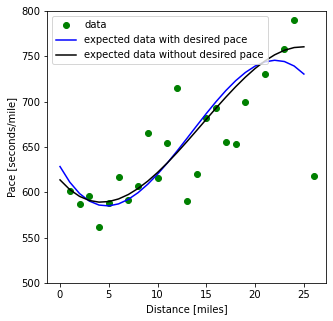

Projected finish time (with a desired end pace): [737.9830825404646, 733.6578086517366, 739.3982666989583, 721.4749206977717, 724.093667644972, 723.3544229462723, 715.5156708059588, 710.6522633845267, 708.7791800084112, 702.1641965180363, 697.8416099023459, 695.1807001250615, 687.0779711458039, 681.1050974196648, 677.5686921710235, 674.0722134618087, 668.4414019337901, 662.5830411385869, 660.3267119410299, 669.4757250862331, 669.716009476348, 686.4445819639088, 693.4497842987483, 712.4522755512601, 761.007828011702, 717.2192461619834]
Projected finish time (withOUT a desired end pace): [2742633.793871796, -328366.98261110805, 30272.92369967011, -26998.23978725162, 9540.383619926984, 7226.041560001711, -1862.4175482687751, -776.836968491863, 2135.1071374956005, -475.20490579584737, 144.94293877715262, 1255.1353952268719, -613.3883939099192, -468.2207756664692, 291.05400199442977, 615.5758928608373, 519.6924447953336, 498.45643093193155, 649.4272525158611, 937.8109908845597, 867.07181853

In [36]:
# apply "black box" function to second dataset
total_pace_list = data2["Race 1"] # use the first race data as the "live" data
ftime = 1030 # desired end pace

Running(data2,total_pace_list,ftime,fit="D3") # running the function for D=3

By comparing the end race paces to the desired end race pace, you can see a discrapancy between the values indicating that a better model is needed. 

## Conclusion

- Limitations 
    - Need more data!
        - More runners with more splits
        - Races usually don’t provide a lot of splits
        - My splits are limited to what I’ve tracked
        - More physiological variation
        - More races with different terrain 
    - Previous training methods, injuries, weather conditions, etc. were not taken into account
- Next Steps
    - Use regression analysis models to determine a more accurate model
    - Determine final race time rather than just final pace
        - Looking into Nike Breaking2 project (maybe it is open source?)
- Answer to research question:
    - It’s difficult to find an accurate model with little data
    - The paces predicted were not completely usless when a desired pace was indicated (somewhat contained the model)
    - Without a desired pace, in higher degree polynomial fits the prediction would be extremely inaccurate (and not possible)
- With this code, you can roughly determine final race pace


### References

_(List the source(s) for any data and/or literature cited in your project.  Ideally, this should be formatted using a formal citation format (MLA or APA or other, your choice!).   Multiple free online citation generators are available such as <a href="http://www.easybib.com/style">http://www.easybib.com/style</a>. **Important:** if you use **any** code that you find on the internet for your project you **must** cite it or you risk losing most/all of the points for your project.)_

$^1$ “84 Marathon Statistics You Should Know.” LIVESTRONG.COM, Leaf Group, https://www.livestrong.com/article/13763749-marathon-statistics/. 

$^2$ "RunRaceResults." UNKNOWN, https://www.runraceresults.com/Secure/RaceResults.cfm?ID=RCLF2015.

$^3$ “Gaussian Processes Regression: Basic Introductory Example.” Scikit, https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html. 

$^4$ “Logistic Function.” Wikipedia, Wikimedia Foundation, 3 Dec. 2021, https://en.wikipedia.org/wiki/Logistic_function. 